# 勾配消失問題
多層パーセプトロンでは、層の長さを長くすればするほど表現力は増します。一方で、学習が難しくなるという問題が知られています。

In [1]:
# PyTorchが使うCPUの数を制限します。(VMを使う場合)
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1

from torch import set_num_threads, set_num_interop_threads
num_threads = 1
set_num_threads(num_threads)
set_num_interop_threads(num_threads)

#ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1


In [2]:
# このセルはヘルパー関数です。

# 上段: ウェイト(wij)の初期値をプロット
def plot_weights(model):
    iLayers = [0, 3, 6, 10]
    labels = [
        ' 0th layer',
        ' 3th layer',
        ' 6th layer',
        'Last layer',
    ]

    values = [model.linears[i].weight.flatten().detach().numpy() for i in iLayers]
    plt.hist(values, bins=50, stacked=False, density=True, label=labels, histtype='step')
    plt.xlabel('weight')
    plt.ylabel('Probability density')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.show()

# 中段: 各ノードの出力(sigma(ai))をプロット
def plot_nodes(model, x):
    iLayers = [0, 3, 6, 10]
    labels = [
        ' 0th layer',
        ' 3th layer',
        ' 6th layer',
        'Last layer',
    ]

    values = [model(x, i).flatten().detach().numpy() for i in iLayers]
    plt.hist(values, bins=50, stacked=False, density=True, label=labels, histtype='step')
    plt.xlabel('activation')
    plt.ylabel('Probability density')
    plt.legend(loc='upper center', fontsize='x-small')
    plt.show()

# 下段: ウェイト(wij)の微分(dE/dwij)をプロット
def plot_gradients(model):
    iLayers = [0, 3, 6, 10]
    labels = [
        ' 0th layer',
        ' 3th layer',
        ' 6th layer',
        'Last layer',
    ]

    grads = [np.abs(model.linears[i].weight.grad.flatten().detach().numpy()) for i in iLayers]
    grads = [np.log10(x[x > 0]) for x in grads]
    plt.hist(grads, bins=50, stacked=False, density=True, label=labels, histtype='step')
    plt.xlabel('log10(|gradient of weights|)')
    plt.ylabel('Probability density')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.show()



中間層が10層という深い多層パーセプトロンを用いて、モデル中の重みパラメータの大きさ、勾配の大きさを調べてみます。

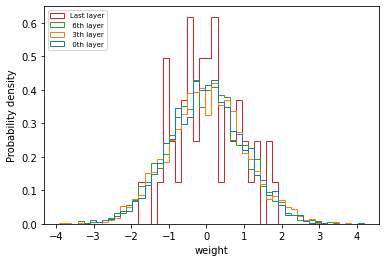

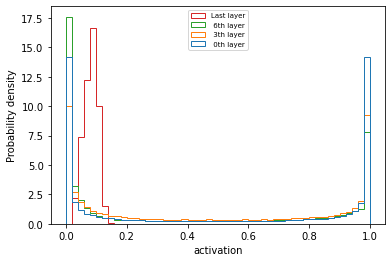

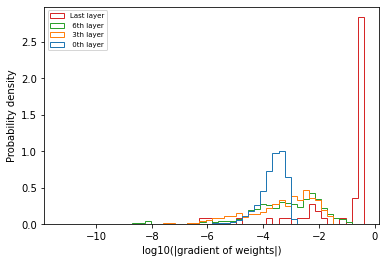

In [3]:
# Modelクラスを継承して新しいクラスを作成します
from torch.nn import Module
from torch.nn import Linear
from torch.nn import Sigmoid

class DeepMLP(Module):
    def __init__(self):
        super().__init__()

        # 中間層が10層の多層パーセプトロン。各レイヤーのノード数は全て50。
        self.linears = []
        self.activations = []
        for i in range(10):
            self.linears += [Linear(in_features=50, out_features=50)]
            self.activations += [Sigmoid()]
        self.linears += [Linear(in_features=50, out_features=1)]
        self.activations += [Sigmoid()]

        # パラメータの初期化
        from torch.nn import init
        for layer in self.linears:
            init.normal_(layer.weight, mean=0.0, std=1.0)  # weight(wij)の初期値。ここでは正規分布に従って初期化する
            init.zeros_(layer.bias)  # bias termの初期値。ここでは0に初期化する。

    def forward(self, inputs, last_node_index=-1):
        x = inputs
        for i, (linear, activation) in enumerate(zip(self.linears, self.activations)):
            x = linear(x)
            x = activation(x)
            if last_node_index >= 0 and i >= last_node_index:
                break
        return x


from torch.nn import BCELoss

# データセットの生成
nSamples = 1000
nFeatures = 50
x = np.random.randn(nSamples, nFeatures)  # 100個の入力変数を持つイベント1000個生成。それぞれの入力変数は正規分布に従う
t = np.random.randint(2, size=nSamples).reshape([nSamples, 1])  # 正解ラベルは0 or 1でランダムに生成

# numpy -> torch.tensor
from torch import from_numpy
x_tensor = from_numpy(x).float()
t_tensor = from_numpy(t).float()

# 中間層が10層の多層パーセプトロン。各レイヤーのノード数は全て50。
model = DeepMLP()

# 順伝搬・逆伝搬をして勾配を計算
y_pred = model(x_tensor)
loss = BCELoss()(y_pred, t_tensor)
loss.backward()

# ウェイト(wij)の初期値をプロット
plot_weights(model)

# 各ノードの出力(sigma(ai))をプロット
plot_nodes(model, x_tensor)

# ウェイト(wij)の微分(dE/dwij)をプロット
plot_gradients(model)


上段のプロットはパラメータ($w_{ij}$)の初期値を表しています。指定したとおり、各層で正規分布に従って初期化されています。
中段のプロットは活性化関数の出力($z_i$)を表しています。パラメータ($w_{ij}$)の初期値として正規分布を指定すると、シグモイド関数の出力はそのほとんどが0か1に非常に近い値となっています。シグモイド関数の微分は$\sigma^{'}(x)=\sigma(x)\cdot(1-\sigma(x))$なので、$\sigma(x)$が0や1に近いときは微分値も非常に小さな値となります。
誤差逆伝播の式は
$$
\begin{align}
\delta_{i}^{(k)} &= \sigma^{'}(a_i^{(k)}) \left( \sum_j w_{ij}^{(k+1)} \cdot \delta_{j}^{(k+1)} \right) \\
\frac{\partial E_n}{\partial w_{ij}^{(k)}}  &= \delta_{j}^{(k)} \cdot z_{i}^{(k)}
\end{align}
$$
でした。$\sigma^{'}(a_i^{(k)})$が小さいと後方の層から前方の層に誤差が伝わる際に、値が小さくなってしまいます。
下段のプロットは各層での$\frac{\partial E_n}{\partial w_{ij}^{(k)}}$を表しています。
前方の層(0th layer)は後方の層と比較して分布の絶対値が小さくなっています。

このように誤差が前の層にいくにつれて小さくなるため、前の層が後ろの層と比較して学習が進まなくなります。
この問題は勾配消失の問題として知られています。

勾配消失はパラメータの初期値や、活性化関数を変更することによって解決・緩和することがわかっています。
PyTorchの
- [初期化のページ](https://pytorch.org/docs/stable/nn.init.html)
- [活性化関数のページ](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

も参考にしながら、この問題の解決を試みてみましょう。

活性化関数・パラメータの初期化方法の変更はモデル定義の中の"activations"、"init"の箇所を変更することによって行えます。

例えばパラメータの初期化を(-0.01, +0.01)の一様分布に変更するときは以下の箇所のコード
```python
init.normal_(layer.weight, mean=0.0, std=1.0)  # weight(wij)の初期値。ここでは正規分布に従って初期化する
```
のようにすれば良いです。
```python
init.uniform_(layer.weight, a=-0.01, b=+0.01)  # weight(wij)の初期値。ここでは一様分布に従って初期化する
```


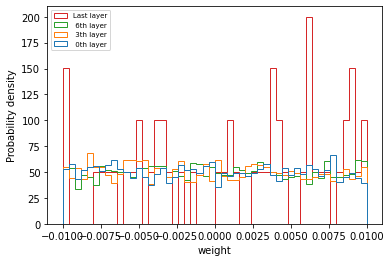

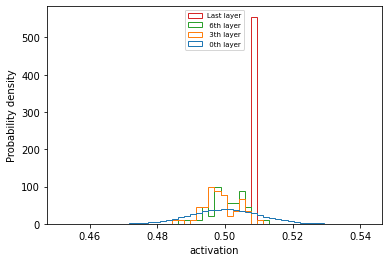

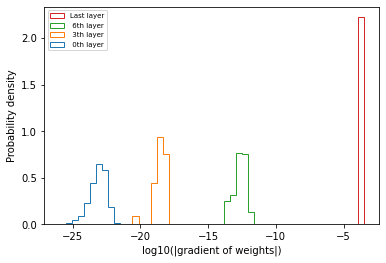

In [4]:
# Modelクラスを継承して新しいクラスを作成します
from torch.nn import Module
from torch.nn import Linear
from torch.nn import Sigmoid

class DeepMLP(Module):
    def __init__(self):
        super().__init__()

        # 中間層が10層の多層パーセプトロン。各レイヤーのノード数は全て50。
        self.linears = []
        self.activations = []
        for i in range(10):
            self.linears += [Linear(in_features=50, out_features=50)]
            self.activations += [Sigmoid()]
        self.linears += [Linear(in_features=50, out_features=1)]
        self.activations += [Sigmoid()]

        # パラメータの初期化
        from torch.nn import init
        for layer in self.linears:
            '''
                CHANGED: 変更箇所 ここから
            '''
            init.uniform_(layer.weight, a=-0.01, b=+0.01)  # weight(wij)の初期値。ここでは一様分布に従って初期化する
            '''
                CHANGED: 変更箇所 ここまで
            '''
            init.zeros_(layer.bias)  # bias termの初期値。ここでは0に初期化する。

    def forward(self, inputs, last_node_index=-1):
        x = inputs
        for i, (linear, activation) in enumerate(zip(self.linears, self.activations)):
            x = linear(x)
            x = activation(x)
            if last_node_index >= 0 and i >= last_node_index:
                break
        return x

from torch.nn import BCELoss

# データセットの生成
nSamples = 1000
nFeatures = 50
x = np.random.randn(nSamples, nFeatures)  # 100個の入力変数を持つイベント1000個生成。それぞれの入力変数は正規分布に従う
t = np.random.randint(2, size=nSamples).reshape([nSamples, 1])  # 正解ラベルは0 or 1でランダムに生成

# numpy -> torch.tensor
from torch import from_numpy
x_tensor = from_numpy(x).float()
t_tensor = from_numpy(t).float()

# 中間層が10層の多層パーセプトロン。各レイヤーのノード数は全て50。
model = DeepMLP()

# 順伝搬・逆伝搬をして勾配を計算
y_pred = model(x_tensor)
loss = BCELoss()(y_pred, t_tensor)
loss.backward()

# ウェイト(wij)の初期値をプロット
plot_weights(model)

# 各ノードの出力(sigma(ai))をプロット
plot_nodes(model, x_tensor)

# ウェイト(wij)の微分(dE/dwij)をプロット
plot_gradients(model)


この例では活性化関数の出力が0.5付近に集中しています。
どのノードも同じ出力をしているということはノード数を増やした意味があまりなくなっており、多層パーセプトロンの表現力が十分に活かしきれていないことがわかります。
また、勾配消失も先程の例と比較して大きくなっています。